# ------------------------------------- BUISNESS PROBLEM -----------------------------------------

The business problem tackled here is trying to improve customer
service for YourCabs.com, a cab company in Bangalore.

The problem of interest is booking cancellations by the company
due to unavailability of a car. The challenge is that cancellations
can occur very close to the trip start time, thereby causing
passengers inconvenience.

Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from patsy import dmatrices
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score



Reading the Dataset

In [2]:
%cd "C:\Users\Welcome\Desktop\Power_Bi\Python\cen"
df = pd.read_csv('YourCabs_training.csv')

C:\Users\Welcome\Desktop\Power_Bi\Python\cen


Exploring the dataset

In [3]:
df.head().T

,0,1,2,3,4
id,132512,132513,132514,132515,132517
user_id,22177,21413,22178,13034,22180
vehicle_model_id,28,12,12,12,12
package_id,NaN,NaN,NaN,NaN,NaN
travel_type_id,2,2,2,2,2
from_area_id,83.0,1010.0,1301.0,768.0,1365.0
to_area_id,448.0,540.0,1034.0,398.0,849.0
from_city_id,NaN,NaN,NaN,NaN,NaN
to_city_id,NaN,NaN,NaN,NaN,NaN
from_date,1/1/2013 2:00,1/1/2013 9:00,1/1/2013 3:30,1/1/2013 5:45,1/1/2013 9:00


# Columns Description.



id - booking ID

user_id - the ID of the customer (based on mobile number)

vehicle_model_id - vehicle model type.

package_id - type of package (1=4hrs & 40kms, 2=8hrs & 80kms, 3=6hrs & 60kms, 4= 10hrs & 100kms, 5=5hrs & 50kms, 6=3hrs &
30kms, 7=12hrs & 120kms)

travel_type_id - type of travel (1=long distance, 2= point to point, 3= hourly rental).

from_area_id - unique identifier of area. Applicable only for point-to-point travel and packages

to_area_id - unique identifier of area. Applicable only for point-to-point travel

from_city_id - unique identifier of city

to_city_id - unique identifier of city (only for intercity)

from_date - time stamp of requested trip start

to_date - time stamp of trip end

online_booking - if booking was done on desktop website

mobile_site_booking - if booking was done on mobile website

booking_created - time stamp of booking

from_lat - latitude of from area

from_long - longitude of from area

to_lat - latitude of to area

to_long - longitude of to area

Car_Cancellation (available only in training data) - whether the booking was cancelled (1) or not (0) due to unavailability of a car.

Cost_of_error (available only in training data) - the cost incurred if the booking is misclassified. For an un-cancelled booking, the cost of
misclassificaiton is 1. For a cancelled booking, the cost is a function of the cancellation time relative to the trip start time



# Exploring the Dataset

In [90]:
df.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error,time_gap,weekday,hour
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,2013-01-01 02:00:00,...,2013-01-01 01:39:00,12.924150,77.672290,12.927320,77.635750,0,1.0,1260.0,Tuesday,2
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,2013-01-01 09:00:00,...,2013-01-01 02:25:00,12.966910,77.749350,12.927680,77.626640,0,1.0,23700.0,Tuesday,9
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,2013-01-01 03:30:00,...,2013-01-01 03:08:00,12.937222,77.626915,13.047926,77.597766,0,1.0,1320.0,Tuesday,3
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,2013-01-01 05:45:00,...,2013-01-01 04:39:00,12.989990,77.553320,12.971430,77.639140,0,1.0,3960.0,Tuesday,5
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,2013-01-01 09:00:00,...,2013-01-01 07:53:00,12.845653,77.677925,12.954340,77.600720,0,1.0,4020.0,Tuesday,9


In [5]:
def continous_summary(x):
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    n_per_miss = n_miss*100/n_total
    
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5*iqr
    uc_iqr = q3 + 1.5*iqr
    
    return pd.Series([x.dtype,n_total,x.count(),x.nunique(),n_miss,n_per_miss,x.sum(),x.mean(),x.std(),x.var(),x.min(),
                      x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), x.quantile(0.25), x.quantile(0.50), x.quantile(0.75),
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99),x.max()],
                      
                     index=['dtype','total','count','no of unique','total miss','per_miss','sum','avg','sd','var','min',
                           'p(0.01)','p(0.05)','p(0.10)','p(0.25)','p(0.50)','p(0.75)','p(0.90)','p(0.95)','p(0.99)','max'
                           ]
                     
                     )

In [6]:
# Reading the Columns in dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  to_date              25541 non-null  float64
 11  online_booking       43431 non-null  int64  
 12  mobile_site_booking  43431 non-null  int64  
 13  booking_created      43431 non-null  object 
 14  from_lat             43338 non-null  float64
 15  from_long            43338 non-null 

In [7]:
# Dimensions of the dataset

df.shape

(43431, 20)

In [8]:
# Seperating columns in dataset

df_continous = df.select_dtypes(exclude='object')
df_categorical = df.select_dtypes(include='object')

In [9]:
# Reading numerical columns in dataset

df_continous.apply(continous_summary)

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,to_date,online_booking,mobile_site_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,Cost_of_error
dtype,int64,int64,int64,float64,int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64
total,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431,43431
count,43431,43431,43431,7550,43431,43343,34293,16345,1588,25541,43431,43431,43338,43338,34293,34293,43431,43431
no of unique,43431,22267,27,7,3,598,568,3,116,22151,2,2,466,462,450,447,2,70
total miss,0,0,0,35881,0,88,9138,27086,41843,17890,0,0,93,93,9138,9138,0,0
per_miss,0.0,0.0,0.0,82.616104,0.0,0.20262,21.040271,62.365591,96.343626,41.191775,0.0,0.0,0.214133,0.214133,21.040271,21.040271,0.0,0.0
sum,6914496353,1335034115,1116925,15327.0,92823,30970502.0,22958852.0,243787.0,108838.0,1060155185.38155,15270,1878,562633.889765,3364600.005697,446722.856466,2662528.939618,3132,347470.1
avg,159206.473556,30739.198153,25.71723,2.030066,2.137252,714.544494,669.490917,14.915081,68.537783,41507.97484,0.351592,0.043241,12.982461,77.636255,13.026648,77.640595,0.072114,8.000509
sd,15442.386279,10996.476709,26.79825,1.461756,0.437712,419.883553,400.638225,1.165306,49.880732,305.144945,0.477473,0.203402,0.085933,0.059391,0.113487,0.064045,0.25868,25.350698
var,238467293.999526,120922500.011208,718.146219,2.13673,0.191592,176302.197913,160510.987356,1.357938,2488.087418,93113.437426,0.22798,0.041372,0.007384,0.003527,0.012879,0.004102,0.066915,642.657895


In this we can understand the important key metrics - Eg(sum,avg,sd,min,max) and value range of all numerical columns in the dataset

In [10]:
df_categorical.describe()

,from_date,booking_created
count,43431,43431
unique,20377,39349
top,10/12/2013 6:00,10/31/2013 10:30
freq,20,18


Calculating Missing values in dataset

In [11]:
df.isna().sum()

id                         0
user_id                    0
vehicle_model_id           0
package_id             35881
travel_type_id             0
from_area_id              88
to_area_id              9138
from_city_id           27086
to_city_id             41843
from_date                  0
to_date                17890
online_booking             0
mobile_site_booking        0
booking_created            0
from_lat                  93
from_long                 93
to_lat                  9138
to_long                 9138
Car_Cancellation           0
Cost_of_error              0
dtype: int64

In [12]:
correlation = df_continous.corr()['Car_Cancellation']
print(correlation)


id                     0.134326
user_id                0.102789
vehicle_model_id      -0.045244
package_id             0.071583
travel_type_id        -0.023360
from_area_id           0.011357
to_area_id             0.066088
from_city_id           0.024755
to_city_id            -0.007882
to_date                0.035766
online_booking         0.149476
mobile_site_booking    0.067204
from_lat              -0.076085
from_long              0.042811
to_lat                -0.127288
to_long               -0.102121
Car_Cancellation       1.000000
Cost_of_error          0.990560
Name: Car_Cancellation, dtype: float64


In [13]:
correlation[correlation>0].index

Index(['id', 'user_id', 'package_id', 'from_area_id', 'to_area_id',
       'from_city_id', 'to_date', 'online_booking', 'mobile_site_booking',
       'from_long', 'Car_Cancellation', 'Cost_of_error'],
      dtype='object')

In [14]:
df1 = df[['vehicle_model_id','travel_type_id', 'package_id', 'from_area_id', 'to_area_id',
       'from_city_id', 'to_date', 'online_booking', 'mobile_site_booking',
       'from_long', 'Car_Cancellation', 'Cost_of_error']]

In [15]:
df1.isna().sum()

vehicle_model_id           0
travel_type_id             0
package_id             35881
from_area_id              88
to_area_id              9138
from_city_id           27086
to_date                17890
online_booking             0
mobile_site_booking        0
from_long                 93
Car_Cancellation           0
Cost_of_error              0
dtype: int64

Missing Value Treatment on Numerical Columns

Since there are so many missing values in the numerical columns. will fill all the cumerical columns with their missing values for model prediction. Then for analysis will build the model based on that

In [16]:
df_continous_new = df1.apply(lambda x:x.fillna(x.mean()))

In [17]:
df_continous_new.isna().sum()

vehicle_model_id       0
travel_type_id         0
package_id             0
from_area_id           0
to_area_id             0
from_city_id           0
to_date                0
online_booking         0
mobile_site_booking    0
from_long              0
Car_Cancellation       0
Cost_of_error          0
dtype: int64

Missing Value Treatment on Categorical Columns

In [18]:
df_categorical.isna().sum()


from_date          0
booking_created    0
dtype: int64

Since there is no missing values in categorical values no need to perform missing value treatments

In [19]:
df_categorical['from_date'].value_counts()

10/12/2013 6:00    20
7/4/2013 22:15     20
9/8/2013 6:00      16
5/12/2013 7:30     15
9/16/2013 8:00     13
                   ..
5/30/2013 21:30     1
5/31/2013 6:30      1
5/31/2013 12:00     1
5/31/2013 15:30     1
11/25/2013 5:00     1
Name: from_date, Length: 20377, dtype: int64

We can see that in numerical and categorical columns date time values are present with numerical and string data types we will convert them into date time data types

# Excluding Cost_of_error column all other numerical columns in dataset are representing a character/feature, outliers cant be checked or updated for that columns. Hence performing outliers calculation only on Cost_of_error column

In [102]:
df_continous_new['Cost_of_error'] = pd.to_numeric(df_continous_new['Cost_of_error'], errors='coerce')


df_continous_new['Cost_of_error'] = df_continous_new['Cost_of_error'].clip(lower=df_continous_new['Cost_of_error'].quantile(0.01),
                                                                           upper=df_continous_new['Cost_of_error'].quantile(0.99))


In [98]:
df_new  = pd.concat([df_continous_new,df_categorical],axis=1)

In [99]:
df_new.shape

(43431, 14)

In [100]:
df_new.isna().sum()

vehicle_model_id       0
travel_type_id         0
package_id             0
from_area_id           0
to_area_id             0
from_city_id           0
to_date                0
online_booking         0
mobile_site_booking    0
from_long              0
Car_Cancellation       0
Cost_of_error          0
from_date              0
booking_created        0
dtype: int64

In [23]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vehicle_model_id     43431 non-null  int64  
 1   travel_type_id       43431 non-null  int64  
 2   package_id           43431 non-null  float64
 3   from_area_id         43431 non-null  float64
 4   to_area_id           43431 non-null  float64
 5   from_city_id         43431 non-null  float64
 6   to_date              43431 non-null  float64
 7   online_booking       43431 non-null  int64  
 8   mobile_site_booking  43431 non-null  int64  
 9   from_long            43431 non-null  float64
 10  Car_Cancellation     43431 non-null  int64  
 11  Cost_of_error        43431 non-null  float64
 12  from_date            43431 non-null  object 
 13  booking_created      43431 non-null  object 
dtypes: float64(7), int64(5), object(2)
memory usage: 4.6+ MB


# Updating the datetime datatype of respected columns and updating their format 

In [24]:
df_new['to_date'] = pd.to_datetime(df_new['to_date'], origin='1899-12-30', unit='D')

In [25]:
df_new['to_date'] = pd.to_datetime(df_new['to_date'], format='%m/%d/%Y %H:%M')

In [26]:
df_new['booking_created'] = pd.to_datetime(df_new['booking_created'], format='%m/%d/%Y %H:%M')

<Axes: >

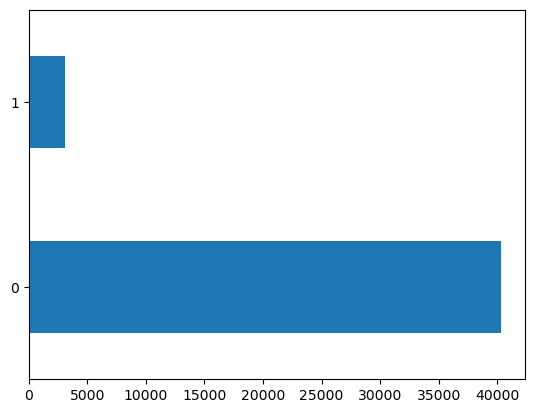

In [27]:
df_new['Car_Cancellation'].value_counts().plot(kind='barh')

Since there is more number of cancellation we will proceed model building with sample of same size in both cancellation and non-cancellation

In [28]:
not_cancelled = df_new[df_new.Car_Cancellation == 0]
cancelled = df_new[df_new.Car_Cancellation == 1]

In [29]:
not_cancelled_sample = not_cancelled.sample(n=3132)

In [30]:
merged_df = pd.concat([not_cancelled_sample, cancelled], axis=0)

In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6264 entries, 19491 to 43422
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   vehicle_model_id     6264 non-null   int64         
 1   travel_type_id       6264 non-null   int64         
 2   package_id           6264 non-null   float64       
 3   from_area_id         6264 non-null   float64       
 4   to_area_id           6264 non-null   float64       
 5   from_city_id         6264 non-null   float64       
 6   to_date              6264 non-null   datetime64[ns]
 7   online_booking       6264 non-null   int64         
 8   mobile_site_booking  6264 non-null   int64         
 9   from_long            6264 non-null   float64       
 10  Car_Cancellation     6264 non-null   int64         
 11  Cost_of_error        6264 non-null   float64       
 12  from_date            6264 non-null   object        
 13  booking_created      6264 no

In [32]:
merged_df = merged_df[['vehicle_model_id','travel_type_id', 'package_id', 'from_area_id', 'to_area_id',
       'from_city_id', 'online_booking', 'mobile_site_booking', 'Car_Cancellation', 'Cost_of_error']]

# Exploratory data analysis

In [33]:
cancellation_rate = df['Car_Cancellation'].mean()
print(f"Overall cancellation rate: {cancellation_rate:.2%}")


Overall cancellation rate: 7.21%


<Axes: >

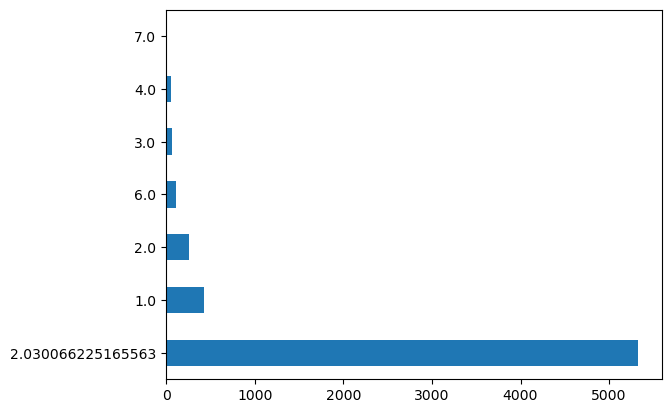

In [34]:
merged_df['package_id'].value_counts().plot(kind='barh')

We can see that customers mostly prefer to travel between 4 hours and 40 kms to 8 hours and 80 kms. It is also general that most of the customers travel mostly between 1 to 1.5 buisness days in cab.

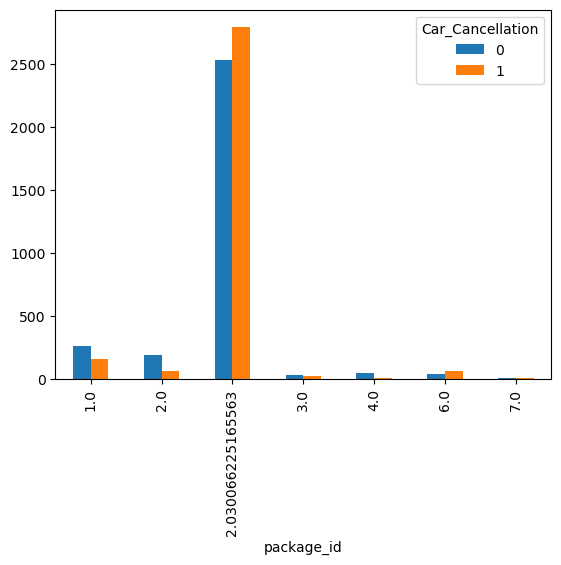

In [35]:
result = merged_df.groupby('package_id')['Car_Cancellation'].value_counts().unstack().fillna(0)
result.plot(kind='bar')
plt.show()


We can see that non cancellation is higher in less than 2 package-id whereas if you go higher than 2 package-id cancellation is higher than non-cancellation of cars due to availability

In [36]:
booking_percentage = merged_df[['online_booking', 'mobile_site_booking']].mean() * 100
print(booking_percentage)


online_booking         46.487867
mobile_site_booking     6.944444
dtype: float64


By this it proves most of the people prefer online booking instead of mobile site-booking

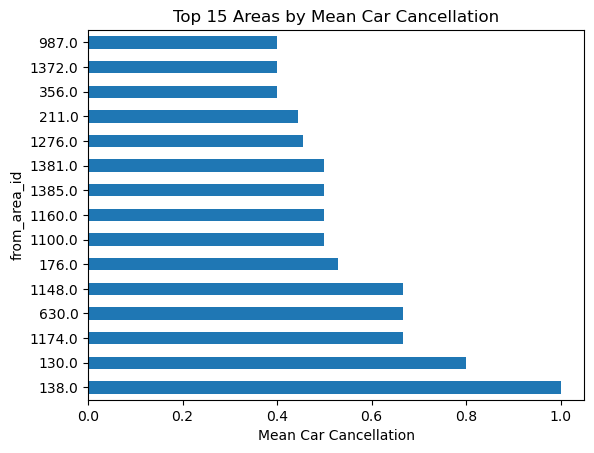

In [37]:
import matplotlib.pyplot as plt

# Grouping by 'from_area_id' and calculating mean 'Car_Cancellation'
cancellation_by_area = df.groupby('from_area_id')['Car_Cancellation'].mean()

# Sorting the values to get the top 15
top_15_areas = cancellation_by_area.sort_values(ascending=False).head(15)

# Plotting the top 15 areas
top_15_areas.plot(kind='barh')
plt.xlabel('Mean Car Cancellation')
plt.ylabel('from_area_id')
plt.title('Top 15 Areas by Mean Car Cancellation')
plt.show()


In [38]:
correlation = df[['Car_Cancellation', 'Cost_of_error']].corr()
print(correlation)


                  Car_Cancellation  Cost_of_error
Car_Cancellation           1.00000        0.99056
Cost_of_error              0.99056        1.00000


It proves a strong co-relationship between car cancellation and cost of error it directly proportional to each other

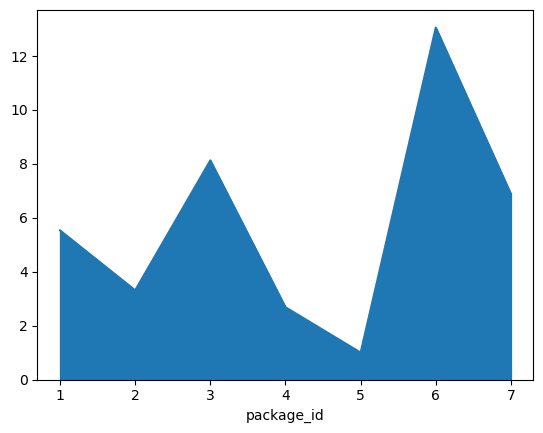

In [39]:
avg_cost_per_package = df.groupby('package_id')['Cost_of_error'].mean().plot(kind='area')
#print(avg_cost_per_package)


Cost of error reaches high proportionally with increase in package-id(more the distance and duration more the cost of error)

<Axes: >

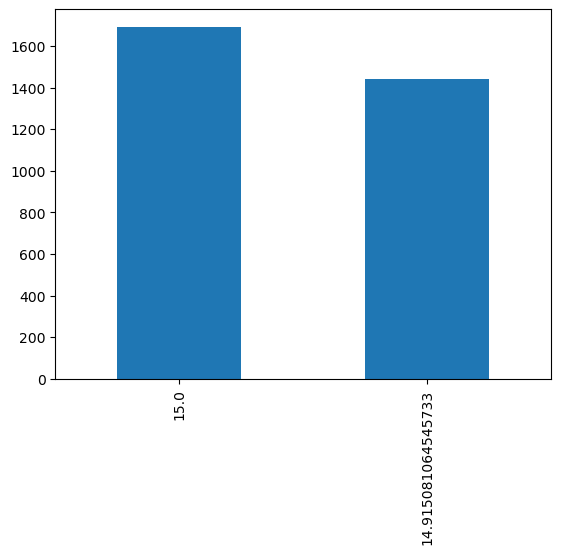

In [40]:
merged_df[merged_df['Car_Cancellation'] == 1]['from_city_id'].value_counts().plot(kind='bar')

From the above visualization residents from city_id 15 has requested for 99% of cancellation compared to other city_id. there are not residents from 14.9 they are mostly in response to city id 15

In [41]:
unique_users_with_cancellation = df[df['Car_Cancellation'] == 1]['user_id'].nunique()
print("Total unique users with cancellation : ",unique_users_with_cancellation)


Total unique users with cancellation :  2622


In [42]:
avg_to_area_for_cancellation = df.groupby('Car_Cancellation')['to_area_id'].mean()
print(avg_to_area_for_cancellation)


Car_Cancellation
0    661.634621
1    758.721441
Name: to_area_id, dtype: float64


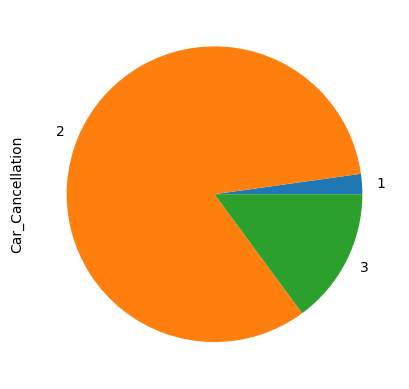

In [43]:
cancellation_by_travel_type = merged_df.groupby('travel_type_id')['Car_Cancellation'].count().plot(kind='pie')


Most of the customers point to point cab ride is getting cancelled due to car un-availability. Its because due the cars booked hourly rental more which are always in booked point to point customers are finding difficult to book a ride

In [44]:
correlation_online_booking = merged_df['online_booking'].corr(merged_df['Car_Cancellation'])
print(f"Correlation between online_booking and Car_Cancellation: {correlation_online_booking:.2f}")


Correlation between online_booking and Car_Cancellation: 0.29


In [45]:
cost_error_by_cancellation = merged_df.groupby('Car_Cancellation')['Cost_of_error'].mean()
print("Cost error mean by non-cancellation rides : ", cost_error_by_cancellation[0])
print("Cost error mean by cancellation rides : ", cost_error_by_cancellation[1])

Cost error mean by non-cancellation rides :  1.0
Cost error mean by cancellation rides :  98.0750638569604


Axes(0.125,0.11;0.775x0.77)


Text(0.5, 1.0, 'Top 5 area id with high cancellation cab rides')

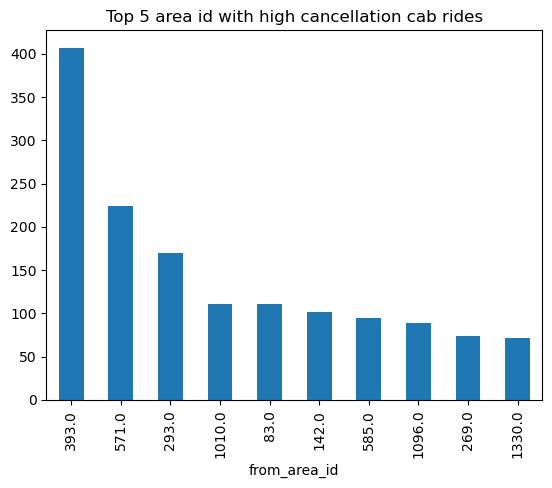

In [46]:
cancellation_by_area = merged_df.groupby('from_area_id')['Car_Cancellation'].count().sort_values(ascending=False)
top_high_cancellation_areas = cancellation_by_area.head(10)  # Top 5 areas with high cancellation rate
print(top_high_cancellation_areas.plot(kind='bar'))
plt.title("Top 5 area id with high cancellation cab rides")


In [47]:
cancellation_by_vehicle = merged_df.groupby('vehicle_model_id')['Car_Cancellation','Cost_of_error'].sum().sort_values(by='Cost_of_error',ascending=False)
print(cancellation_by_vehicle)


                  Car_Cancellation  Cost_of_error
vehicle_model_id                                 
12                            2668      264005.15
89                             298       29790.41
28                              76        7558.78
65                              59        5805.14
87                              16        1439.01
85                               9        1083.00
24                               3         319.30
91                               2         108.31
13                               1         100.00
90                               0          34.00
23                               0          26.00
86                               0           9.00
64                               0           8.00
10                               0           6.00
17                               0           4.00
54                               0           4.00
70                               0           1.00
36                               0           1.00


C:\Users\Welcome\AppData\Local\Temp\ipykernel_32484\1174320797.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cancellation_by_vehicle = merged_df.groupby('vehicle_model_id')['Car_Cancellation','Cost_of_error'].sum().sort_values(by='Cost_of_error',ascending=False)


In [48]:
print("Top 5 vehicle-id's contribution to total cost of error amount : "  ,(cancellation_by_vehicle['Cost_of_error'].head(5).sum() / cancellation_by_vehicle['Cost_of_error'].sum())*100, ". We can see that nearly total cost of error has been made from top 5 vehicle id-s so validating the reason behind the poor perfomance from those vehicles and sorting out the issues will create a major impact on reducing the car cancellation")

Top 5 vehicle-id's contribution to total cost of error amount :  99.45066291635504 . We can see that nearly total cost of error has been made from top 5 vehicle id-s so validating the reason behind the poor perfomance from those vehicles and sorting out the issues will create a major impact on reducing the car cancellation


In [49]:
df['booking_created'] = pd.to_datetime(df['booking_created'])
df['from_date'] = pd.to_datetime(df['from_date'])
df['time_gap'] = (df['from_date'] - df['booking_created']).dt.total_seconds()
correlation_time_gap = df['time_gap'].corr(df['Car_Cancellation'])
print(f"Correlation between time gap and Car_Cancellation: {correlation_time_gap:.2f}")


Correlation between time gap and Car_Cancellation: 0.02


Its been proved that there is positive co-relationship between time gap and car_cancellation. More the time takes to completed the ride the more the cancelation increases for new customers due to car un-availability

Axes(0.125,0.11;0.775x0.77)


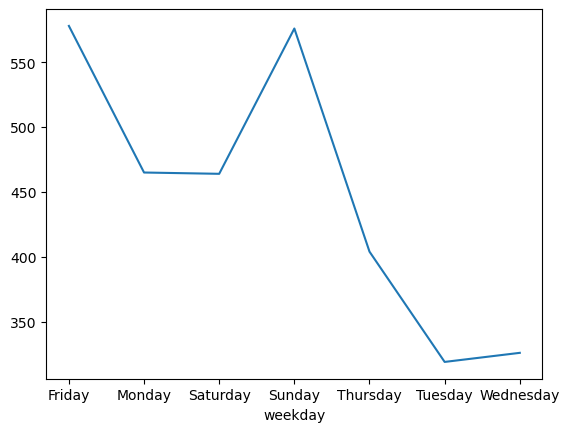

In [50]:
df['from_date'] = pd.to_datetime(df['from_date'])
df['weekday'] = df['from_date'].dt.day_name()
cancellation_by_weekday = df.groupby('weekday')['Car_Cancellation'].sum()
print(cancellation_by_weekday.plot(kind='line'))


From line chart, we can see the no of cancellation is high over the pre-weekend days and weekend days is higher compared to weekdays - Friday,Saturday,Sunday is higher than other days.

Also from previous analysis we can see that most of the customers are getting cancelled of travel type is point to point and minimum distance and time consuming travel rides. 

In week-ends most of the rides have benn booked for the long trip hence the car isnt available to most of customers for point to point travel rides

Axes(0.125,0.11;0.775x0.77)


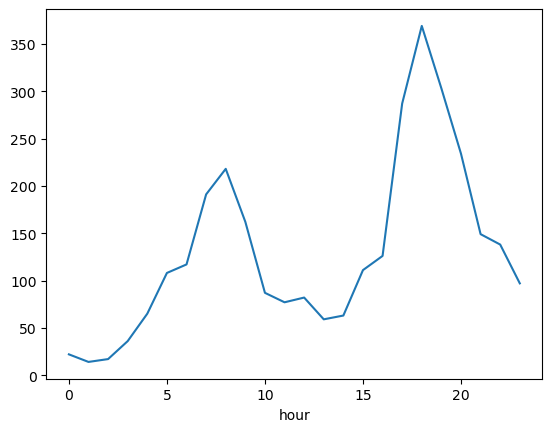

In [51]:
df['hour'] = df['from_date'].dt.hour
cancellation_by_hour = df.groupby('hour')['Car_Cancellation'].sum()
print(cancellation_by_hour.plot(kind='line'))

We can see that total cancelled rides is higher after 16:00 PM(Evening 7 PM).

<Axes: >

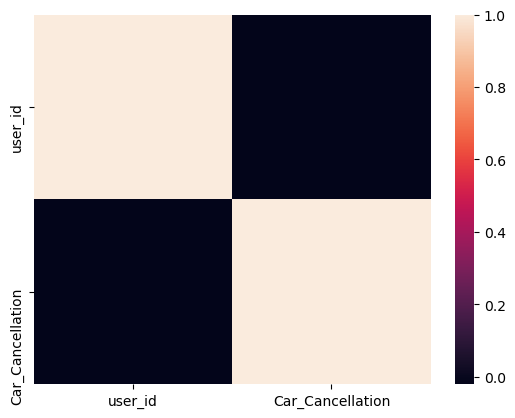

In [52]:
booking_frequency = df['user_id'].value_counts()
user_cancellation_rate = df.groupby('user_id')['Car_Cancellation'].mean()
booking_cancellation_corr = pd.concat([booking_frequency, user_cancellation_rate], axis=1)
sns.heatmap(booking_cancellation_corr.corr())


As per heatmap, it clearly indictes customer unique user id and car cancellation is not proportional/related to each other

Text(0.5, 0, 'Date')

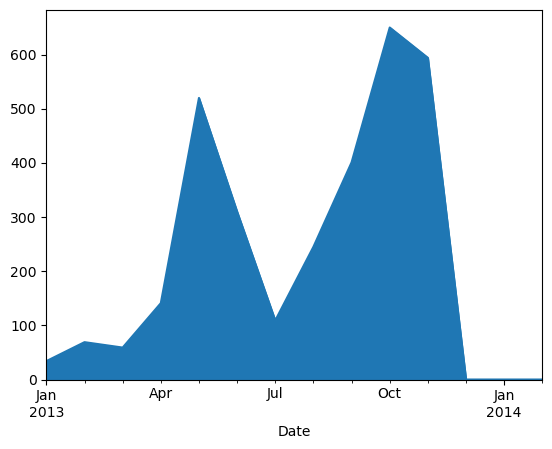

In [53]:
df['from_date'] = pd.to_datetime(df['from_date'])
cancellation_over_time = df.set_index('from_date')['Car_Cancellation'].resample('M').sum()
cancellation_over_time.plot(kind='area')
plt.xlabel('Date')


From Aug 13 to Dc 2014, saw a major high in no of car cancellation rides in the year- end.

# Splitting the Dataset

In [54]:
X = merged_df.drop(columns='Car_Cancellation', axis=1)
Y = merged_df['Car_Cancellation']

In [55]:
X.columns

Index(['vehicle_model_id', 'travel_type_id', 'package_id', 'from_area_id',
       'to_area_id', 'from_city_id', 'online_booking', 'mobile_site_booking',
       'Cost_of_error'],
      dtype='object')

In [56]:
X = X[['vehicle_model_id', 'travel_type_id', 'package_id', 'from_area_id',
       'to_area_id', 'from_city_id', 'online_booking', 'mobile_site_booking',
       'Cost_of_error']]

In [57]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

# Building and training diffrent models

In [103]:
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'AdaBoostClassifier':AdaBoostClassifier()
    
}

# Train and evaluate each model using cross-validation
for name, model in models.items():
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} accuracy: {scores.mean():.3f} +/- {scores.std():.3f}")
    
    # Fit the model to the full training set and make predictions on the test set
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Evaluate the model on the test set
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1-score: {f1:.3f}")
    print()

C:\Users\Welcome\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Welcome\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Logistic Regression accuracy: 0.996 +/- 0.001
Accuracy: 0.996
Precision: 1.000
Recall: 0.992
F1-score: 0.996

Decision Tree accuracy: 1.000 +/- 0.000
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-score: 1.000

Random Forest accuracy: 0.999 +/- 0.001
Accuracy: 0.998
Precision: 1.000
Recall: 0.997
F1-score: 0.998

SVM accuracy: 0.989 +/- 0.004
Accuracy: 0.989
Precision: 1.000
Recall: 0.978
F1-score: 0.989

GradientBoostingClassifier accuracy: 1.000 +/- 0.000
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-score: 1.000

AdaBoostClassifier accuracy: 1.000 +/- 0.000
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-score: 1.000



# We can see that the least performing model here is logistic regression, previously shortlisted features based on their co-relation car-cancellation feature. 

# Choosing Logistic Regression here because in-spite of the model being the least perfomance model compared to other, wanted to implement feature engineering calculation and validate how much the model perfomance is increasing its efficiency.

# Now we will perform feature selection based on their roc_auc_score then will build logistic regression to increase the effectiveness of precision .

# Feature Engineering Selection

In [59]:
merged_df.head(3)

,vehicle_model_id,travel_type_id,package_id,from_area_id,to_area_id,from_city_id,online_booking,mobile_site_booking,Car_Cancellation,Cost_of_error
19491,12,3,2.000000,182.0,669.490917,14.915081,0,0,0,1.0
30490,12,3,1.000000,344.0,669.490917,15.000000,0,0,0,1.0
11390,12,2,2.030066,393.0,142.000000,14.915081,0,0,0,1.0


In [63]:
train,test = train_test_split(merged_df,test_size = 0.3,random_state=101)

In [67]:
t_df = pd.DataFrame()
for var_name in train.columns.difference(['Car_Cancellation']):
    
    model = smf.logit(formula = 'Car_Cancellation ~ ' + var_name,data = train).fit()
    
    y_predicted = model.predict(train)
    
    r_score = roc_auc_score(train.Car_Cancellation,y_predicted)
    
    sms = 2 * r_score - 1
    
    temp_df = pd.DataFrame([var_name,r_score,sms]).T
    
    t_df = pd.concat([t_df,temp_df],axis=0)

t_df.columns = ['Feature', 'ROC_AUC_SCORE', 'SomarsD']
t_df

Optimization terminated successfully.
         Current function value: 0.021154
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.693136
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652592
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692669
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689169
         Iterations 4


,Feature,ROC_AUC_SCORE,SomarsD
0,Cost_of_error,0.995446,0.990893
0,from_area_id,0.500425,0.00085
0,from_city_id,0.591289,0.182578
0,mobile_site_booking,0.521768,0.043536
0,online_booking,0.641033,0.282067
0,package_id,0.533588,0.067176
0,to_area_id,0.550591,0.101182
0,travel_type_id,0.530046,0.060092
0,vehicle_model_id,0.555124,0.110248


In [70]:
df_2 = list(t_df.loc[t_df['SomarsD'] >=0.1,'Feature'])

In [71]:
df_2

['Cost_of_error',
 'from_city_id',
 'online_booking',
 'to_area_id',
 'vehicle_model_id']

In [73]:
lm_1 = smf.logit(formula = 'Car_Cancellation ~ ' + '+'.join(df_2),data=train).fit()

Optimization terminated successfully.
         Current function value: 0.020626
         Iterations 17


In [74]:
print(lm_1.summary())

                           Logit Regression Results                           
Dep. Variable:       Car_Cancellation   No. Observations:                 4384
Model:                          Logit   Df Residuals:                     4378
Method:                           MLE   Df Model:                            5
Date:                Sun, 19 Nov 2023   Pseudo R-squ.:                  0.9702
Time:                        14:57:28   Log-Likelihood:                -90.425
converged:                       True   LL-Null:                       -3038.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -9.5684     12.072     -0.793      0.428     -33.229      14.093
Cost_of_error        2.7061      0.514      5.265      0.000       1.699       3.713
from_city_id         0.0624 

In [76]:
train_score = roc_auc_score(train.Car_Cancellation,lm_1.predict(train))
test_score = roc_auc_score(test.Car_Cancellation,lm_1.predict(test))

print("Train Score : ",train_score)
print("Test Score : ",test_score)

Train Score :  0.9959018474673913
Test Score :  0.9977738392727801


In [79]:
train_predicted_prob = pd.DataFrame(lm_1.predict(train))

train_df = pd.concat([train.Car_Cancellation,train_predicted_prob],axis=1)

train_df.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(lm_1.predict(test))

test_df = pd.concat([test.Car_Cancellation,test_predicted_prob],axis=1)

test_df.columns = ['actual','prob']

In [80]:
train_df_1 = pd.DataFrame()

for i in np.arange(0,1.01,0.01):
    
    train_df['predicted'] = train_df.prob.apply(lambda x : 1 if x > i else 0)
    
    cm = confusion_matrix(train_df.actual,train_df.predicted)
    
    tp = cm[1,1]
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tpr = tp / (tp+fn)
    fpr = fp / (tn+fp)
    specificity = 1 - fpr
    ss = tpr + specificity
    accuracy = (tp + tn)/train_df.shape[0]
    
    temp_df = pd.DataFrame([i,tp,tn,fp,fn,tpr,fpr,specificity,accuracy,ss]).T
    
    train_df_1 = pd.concat([train_df_1,temp_df],axis = 0)
    
train_df_1.columns = ['p','tp','tn','fp','fn','tpr','fpr','specificity','accuracy','ss']
    

In [81]:
train_df_1.loc[train_df_1.ss == train_df_1.ss.max(),'p']

0    0.02
0    0.03
Name: p, dtype: float64

In [82]:
test['prob'] = lm_1.predict(test)

In [83]:
test['predicted'] = test.prob.apply(lambda x : 1 if x >= 0.02 else 0)

In [85]:
roc_auc_score(test.Car_Cancellation,test.predicted)

0.9978632478632479

In [86]:
df_new['prob'] = lm_1.predict(df_new)

In [87]:
df_new['predicted'] = df_new.prob.apply(lambda x : 1 if x >= 0.26 else 0)

In [89]:
roc_auc_score(df_new.Car_Cancellation,df_new.predicted)

0.9969667943805876

# Builded a model to predict the car-cancellation rides due to unavailability after data cleansing and analyzin the data and performing feature selection to increase the efficiency and performance of the model. Model is builded up with 99.6% 

In [104]:
X

,vehicle_model_id,travel_type_id,package_id,from_area_id,to_area_id,from_city_id,online_booking,mobile_site_booking,Cost_of_error
19491,12,3,2.000000,182.0,669.490917,14.915081,0,0,1.0
30490,12,3,1.000000,344.0,669.490917,15.000000,0,0,1.0
11390,12,2,2.030066,393.0,142.000000,14.915081,0,0,1.0
3033,12,2,2.030066,585.0,767.000000,14.915081,0,0,1.0
971,12,2,2.030066,585.0,58.000000,14.915081,0,0,1.0
...,...,...,...,...,...,...,...,...,...
43406,12,3,3.000000,136.0,669.490917,15.000000,1,0,100.0
43408,12,3,3.000000,136.0,669.490917,15.000000,1,0,100.0
43411,65,3,4.000000,541.0,669.490917,15.000000,0,1,100.0
43414,12,2,2.030066,376.0,424.000000,15.000000,0,1,100.0
